In [3]:
pip install iterative-stratification


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# ✅ FULL DATASET PREPROCESSING PIPELINE (Kaggle + HuggingFace Compatible)

import os
import zipfile
import requests
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from sklearn.preprocessing import MultiLabelBinarizer
import glob

In [7]:
# 1. Download the dataset ZIP from HuggingFace
url = "https://huggingface.co/datasets/Sugayathri/crx8selected/resolve/main/archive.zip"
zip_path = "/content/archive.zip"
extract_path = "/content/crx8"

if not os.path.exists(zip_path):
    print("📥 Downloading dataset from HuggingFace...")
    r = requests.get(url, stream=True)
    with open(zip_path, 'wb') as f:
        for chunk in r.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)
else:
  print("No Dataset Found")

📥 Downloading dataset from HuggingFace...


In [8]:
# 2. Extract ZIP
if not os.path.exists(extract_path):
    print("📂 Extracting dataset...")
    with zipfile.ZipFile("/content/archive.zip", 'r') as zip_ref:
        zip_ref.extractall(extract_path)


📂 Extracting dataset...


In [9]:
# 3. Load CSVs
data_df = pd.read_csv(os.path.join(extract_path, "Data_Entry_2017.csv"))
bbox_df = pd.read_csv(os.path.join(extract_path, "BBox_List_2017.csv"))

In [10]:
data_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168


In [11]:
bbox_df.head()

,Image Index,Finding Label,Bbox [x,y,w,h],Unnamed: 6,Unnamed: 7,Unnamed: 8
0,00013118_008.png,Atelectasis,225.084746,547.019217,86.779661,79.186441,NaN,NaN,NaN
1,00014716_007.png,Atelectasis,686.101695,131.543498,185.491525,313.491525,NaN,NaN,NaN
2,00029817_009.png,Atelectasis,221.830508,317.053115,155.118644,216.949153,NaN,NaN,NaN
3,00014687_001.png,Atelectasis,726.237288,494.951420,141.016949,55.322034,NaN,NaN,NaN
4,00017877_001.png,Atelectasis,660.067797,569.780787,200.677966,78.101695,NaN,NaN,NaN


📥 Loading CSV files...
✅ Loaded 112120 entries in data_df
✅ Loaded 984 bounding box annotations in bbox_df

🧹 Cleaning and filtering multi-label image data...
📝 Entries after dropping NA labels: 112120
🚫 Removed 60361 'No Finding' entries
✅ Final usable multi-label entries: 35644

🧭 Mapping image filenames to full paths...
🔍 Found 112120 total image files on disk
🧹 Filtered out 0 images not found on disk
🖼️ Total images matched to paths: 35644

🔀 Converting multi-labels to binary matrix...
✅ Converted to binary matrix of shape: (35644, 7)

💾 Saving cleaned dataset to CSV...
✅ File saved: cleaned_multilabel_data.csv

📊 Visualizing class distribution...
Effusion        13317
Atelectasis     11559
Nodule           6331
Mass             5782
Pneumothorax     5302
Cardiomegaly     2776
Pneumonia        1431
dtype: int64


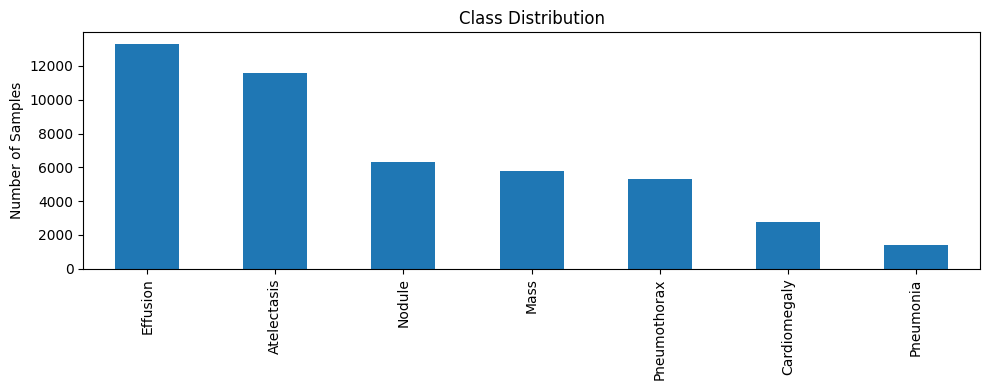


📦 Cleaning bounding box info...
✅ Final bounding boxes: 984


In [12]:
import os
import pandas as pd
import glob
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt

# === Step 1: Load CSVs ===
print("📥 Loading CSV files...")
data_df = pd.read_csv(os.path.join(extract_path, "Data_Entry_2017.csv"))
bbox_df = pd.read_csv(os.path.join(extract_path, "BBox_List_2017.csv"))
print(f"✅ Loaded {len(data_df)} entries in data_df")
print(f"✅ Loaded {len(bbox_df)} bounding box annotations in bbox_df")

# === Step 2: Preprocess Finding Labels ===
print("\n🧹 Cleaning and filtering multi-label image data...")
data_df["Finding Labels"] = data_df["Finding Labels"].str.split("|")
data_df = data_df[["Image Index", "Finding Labels"]].dropna()
print(f"📝 Entries after dropping NA labels: {len(data_df)}")

# Remove "No Finding" cases
initial_len = len(data_df)
data_df = data_df[data_df["Finding Labels"].apply(lambda x: "No Finding" not in x)]
print(f"🚫 Removed {initial_len - len(data_df)} 'No Finding' entries")

# Filter labels based on bbox availability (optional)
valid_labels = bbox_df["Finding Label"].unique().tolist()
data_df["Finding Labels"] = data_df["Finding Labels"].apply(
    lambda labels: [l for l in labels if l in valid_labels]
)
data_df = data_df[data_df["Finding Labels"].map(len) > 0]
print(f"✅ Final usable multi-label entries: {len(data_df)}")

# === Step 3: Map Images to Disk Paths ===
print("\n🧭 Mapping image filenames to full paths...")
image_folder = os.path.join(extract_path, "images")
image_paths = glob.glob(os.path.join(image_folder, "**", "*.png"), recursive=True)
image_map = {os.path.basename(p): p for p in image_paths}
print(f"🔍 Found {len(image_map)} total image files on disk")

data_df["Image Path"] = data_df["Image Index"].map(image_map)
before_filter = len(data_df)
data_df = data_df[data_df["Image Path"].notnull()]
print(f"🧹 Filtered out {before_filter - len(data_df)} images not found on disk")
print(f"🖼️ Total images matched to paths: {len(data_df)}")

# === Step 4: Apply MultiLabelBinarizer ===
print("\n🔀 Converting multi-labels to binary matrix...")
mlb = MultiLabelBinarizer()
Y = mlb.fit_transform(data_df["Finding Labels"])
label_df = pd.DataFrame(Y, columns=mlb.classes_)
print(f"✅ Converted to binary matrix of shape: {label_df.shape}")

data_df = pd.concat([data_df.reset_index(drop=True), label_df], axis=1)

# === Step 5: Save and Visualize ===
print("\n💾 Saving cleaned dataset to CSV...")
data_df.to_csv("cleaned_multilabel_data.csv", index=False)
print("✅ File saved: cleaned_multilabel_data.csv")

print("\n📊 Visualizing class distribution...")
label_counts = label_df.sum().sort_values(ascending=False)
print(label_counts)
label_counts.plot(kind="bar", title="Class Distribution", figsize=(10, 4))
plt.ylabel("Number of Samples")
plt.tight_layout()
plt.show()

# === Optional: Clean bounding boxes for later ===
print("\n📦 Cleaning bounding box info...")
bbox_clean = bbox_df[["Image Index", "Finding Label", "Bbox [x", "y", "w", "h]"]].copy()
bbox_clean.columns = ["Image Index", "Finding Label", "x", "y", "w", "h"]
bbox_clean = bbox_clean.dropna()
print(f"✅ Final bounding boxes: {len(bbox_clean)}")


In [13]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import numpy as np

# Prepare data
image_paths = data_df["Image Path"].tolist()
labels = data_df[mlb.classes_].values.astype(np.float32)

# Initialize 5-fold multi-label stratified split
mskf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("🔀 Starting iterative stratified 5-fold split (multi-label)...")
for fold, (train_idx, val_idx) in enumerate(mskf.split(image_paths, labels)):
    print(f"📁 Fold {fold+1}: Train={len(train_idx)} | Val={len(val_idx)}")


🔀 Starting iterative stratified 5-fold split (multi-label)...
📁 Fold 1: Train=28437 | Val=7207
📁 Fold 2: Train=28533 | Val=7111
📁 Fold 3: Train=28544 | Val=7100
📁 Fold 4: Train=28529 | Val=7115
📁 Fold 5: Train=28533 | Val=7111


In [14]:
import os
import numpy as np
import cv2
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import f1_score, roc_auc_score
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import matplotlib.pyplot as plt

# ========== CONFIG ==========
IMG_SIZE = 512
BATCH_SIZE = 16
EPOCHS = 5
LEARNING_RATE = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SAVE_DIR = "/content/drive/MyDrive/models"
PATIENCE = 8  # Early stopping patience

os.makedirs(SAVE_DIR, exist_ok=True)

# ========== DATASET ==========
class CXRDataset(Dataset):
    def __init__(self, image_paths, labels, transforms=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        try:
            img_path = self.image_paths[idx]
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            gray = clahe.apply(gray)
            gray = np.stack([gray]*3, axis=-1)

            if self.transforms:
                img = self.transforms(image=gray)['image']

            label = torch.tensor(self.labels[idx]).float()
            return img, label
        except Exception as e:
            print(f"❌ Failed loading {img_path}: {e}")
            return None

# ========== TRANSFORMS ==========
def get_transforms():
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.RandomBrightnessContrast(p=0.5),
        A.ElasticTransform(p=0.5),
        A.GridDistortion(p=0.5),
        A.Normalize(mean=[0.5], std=[0.5]),
        ToTensorV2()
    ])

# ========== MODEL ==========
class EnsembleModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.dense = timm.create_model("densenet121", pretrained=True)
        self.dense.classifier = nn.Linear(self.dense.classifier.in_features, num_classes)

        self.efficient = timm.create_model("efficientnet_b3", pretrained=True)
        self.efficient.classifier = nn.Linear(self.efficient.classifier.in_features, num_classes)

    def forward(self, x):
        out1 = self.dense(x)
        out2 = self.efficient(x)
        return (out1 + out2) / 2

# ========== METRICS ==========
def compute_metrics(y_true, y_pred, threshold=0.5):
    y_pred_bin = (y_pred > threshold).astype(int)
    classwise_acc = (y_true == y_pred_bin).mean(axis=0)
    return {
        "f1_macro": f1_score(y_true, y_pred_bin, average="macro"),
        "auroc_macro": roc_auc_score(y_true, y_pred, average="macro"),
        "classwise_acc": classwise_acc,
        "overall_acc": (y_true == y_pred_bin).mean()
    }

# ========== PLOTTING ==========
def plot_metrics(history, class_names, fold):
    epochs = list(range(1, len(history["train_loss"]) + 1))

    plt.figure(figsize=(12, 4))
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Val Loss")
    plt.title("Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.savefig(f"{SAVE_DIR}/fold{fold+1}_loss_curve.png")
    plt.close()

    plt.figure(figsize=(12, 4))
    plt.plot(epochs, history["train_acc"], label="Train Acc")
    plt.plot(epochs, history["val_acc"], label="Val Acc")
    plt.title("Accuracy Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()
    plt.savefig(f"{SAVE_DIR}/fold{fold+1}_acc_curve.png")
    plt.close()

    classwise_acc = np.array(history["val_class_acc"])  # [epochs, classes]
    for i, cname in enumerate(class_names):
        plt.plot(epochs, classwise_acc[:, i], label=cname)
    plt.title("Per-Class Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()
    plt.savefig(f"{SAVE_DIR}/fold{fold+1}_classwise_acc.png")
    plt.close()

# ========== TRAINING LOOP ==========
# def run_training_cv(image_paths, labels, class_names):
#     mskf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#     for fold, (train_idx, val_idx) in enumerate(mskf.split(image_paths, labels)):
#         print(f"\n📁 Fold {fold+1} — Train: {len(train_idx)}, Val: {len(val_idx)}")

#         X_train = [image_paths[i] for i in train_idx]
#         X_val = [image_paths[i] for i in val_idx]
#         y_train = labels[train_idx]
#         y_val = labels[val_idx]

#         train_dataset = CXRDataset(X_train, y_train, transforms=get_transforms())
#         val_dataset = CXRDataset(X_val, y_val, transforms=get_transforms())

#         train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
#         val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

#         model = EnsembleModel(num_classes=labels.shape[1]).to(DEVICE)
#         pos_weight = torch.tensor((y_train.shape[0] / (1 + y_train.sum(axis=0)))).to(DEVICE)
#         criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
#         optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
#         scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

#         history = {
#             "train_loss": [], "val_loss": [],
#             "train_acc": [], "val_acc": [],
#             "val_class_acc": []
#         }

#         best_val_loss = float("inf")
#         best_val_acc = 0
#         no_improve = 0

#         for epoch in range(EPOCHS):
#             print(f"\n📆 Epoch {epoch+1}/{EPOCHS}")

#             # Training
#             model.train()
#             total_loss, correct, count = 0, 0, 0
#             for imgs, labels_ in tqdm(train_loader, desc="🔁 Training"):
#                 imgs, labels_ = imgs.to(DEVICE), labels_.to(DEVICE)
#                 optimizer.zero_grad()
#                 logits = model(imgs)
#                 loss = criterion(logits, labels_)
#                 loss.backward()
#                 optimizer.step()
#                 total_loss += loss.item()
#                 preds = (torch.sigmoid(logits) > 0.5).float()
#                 correct += (preds == labels_).float().mean().item()
#                 count += 1

#             train_loss = total_loss / len(train_loader)
#             train_acc = correct / count
#             print(f"✅ Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")

#             # Validation
#             model.eval()
#             val_loss, val_preds, val_trues = 0, [], []
#             with torch.no_grad():
#                 for imgs, labels_ in tqdm(val_loader, desc="🧪 Validating"):
#                     imgs, labels_ = imgs.to(DEVICE), labels_.to(DEVICE)
#                     logits = model(imgs)
#                     loss = criterion(logits, labels_)
#                     val_loss += loss.item()
#                     val_preds.append(torch.sigmoid(logits).cpu().numpy())
#                     val_trues.append(labels_.cpu().numpy())

#             y_pred = np.vstack(val_preds)
#             y_true = np.vstack(val_trues)
#             val_metrics = compute_metrics(y_true, y_pred)

#             history["train_loss"].append(train_loss)
#             history["val_loss"].append(val_loss / len(val_loader))
#             history["train_acc"].append(train_acc)
#             history["val_acc"].append(val_metrics["overall_acc"])
#             history["val_class_acc"].append(val_metrics["classwise_acc"])

#             print(f"📉 Val Loss: {history['val_loss'][-1]:.4f} | Val Acc: {val_metrics['overall_acc']:.4f} | "
#                   f"F1: {val_metrics['f1_macro']:.4f} | AUROC: {val_metrics['auroc_macro']:.4f}")

#             # Early stopping condition
#             if history["val_loss"][-1] < best_val_loss and val_metrics["overall_acc"] > best_val_acc:
#                 best_val_loss = history["val_loss"][-1]
#                 best_val_acc = val_metrics["overall_acc"]
#                 no_improve = 0
#                 model_path = os.path.join(SAVE_DIR, f"fold{fold+1}_best_model.pt")
#                 torch.save(model.state_dict(), model_path)
#                 print(f"💾 Saved best model to {model_path}")
#             else:
#                 no_improve += 1
#                 print(f"⏸️  No improvement: {no_improve}/{PATIENCE}")
#                 if no_improve >= PATIENCE:
#                     print("🛑 Early stopping triggered.")
#                     break

#             scheduler.step()

#         plot_metrics(history, class_names, fold)

def run_training_cv(image_paths, labels, class_names):
    mskf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for fold, (train_idx, val_idx) in enumerate(mskf.split(image_paths, labels)):
        print(f"\n📁 Fold {fold+1} — Train: {len(train_idx)}, Val: {len(val_idx)}")
        model_path = os.path.join(SAVE_DIR, f"fold{fold+1}_best_model.pt")

        # Check if model already exists
        if os.path.exists(model_path):
            print(f"✅ Model for fold {fold+1} already exists at {model_path}. Loading instead of training...")
            model = EnsembleModel(num_classes=labels.shape[1]).to(DEVICE)
            model.load_state_dict(torch.load(model_path))
            model.eval()
            print(f"📦 Loaded pretrained model. Skipping training for fold {fold+1}.")
            continue

        # Continue with training if model doesn't exist
        X_train = [image_paths[i] for i in train_idx]
        X_val = [image_paths[i] for i in val_idx]
        y_train = labels[train_idx]
        y_val = labels[val_idx]

        train_dataset = CXRDataset(X_train, y_train, transforms=get_transforms())
        val_dataset = CXRDataset(X_val, y_val, transforms=get_transforms())

        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

        model = EnsembleModel(num_classes=labels.shape[1]).to(DEVICE)
        pos_weight = torch.tensor((y_train.shape[0] / (1 + y_train.sum(axis=0)))).to(DEVICE)
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

        history = {
            "train_loss": [], "val_loss": [],
            "train_acc": [], "val_acc": [],
            "val_class_acc": []
        }

        best_val_loss = float("inf")
        best_val_acc = 0
        no_improve = 0

        for epoch in range(EPOCHS):
            print(f"\n📆 Epoch {epoch+1}/{EPOCHS}")

            # Training
            model.train()
            total_loss, correct, count = 0, 0, 0
            for imgs, labels_ in tqdm(train_loader, desc="🔁 Training"):
                imgs, labels_ = imgs.to(DEVICE), labels_.to(DEVICE)
                optimizer.zero_grad()
                logits = model(imgs)
                loss = criterion(logits, labels_)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                preds = (torch.sigmoid(logits) > 0.5).float()
                correct += (preds == labels_).float().mean().item()
                count += 1

            train_loss = total_loss / len(train_loader)
            train_acc = correct / count
            print(f"✅ Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")

            # Validation
            model.eval()
            val_loss, val_preds, val_trues = 0, [], []
            with torch.no_grad():
                for imgs, labels_ in tqdm(val_loader, desc="🧪 Validating"):
                    imgs, labels_ = imgs.to(DEVICE), labels_.to(DEVICE)
                    logits = model(imgs)
                    loss = criterion(logits, labels_)
                    val_loss += loss.item()
                    val_preds.append(torch.sigmoid(logits).cpu().numpy())
                    val_trues.append(labels_.cpu().numpy())

            y_pred = np.vstack(val_preds)
            y_true = np.vstack(val_trues)
            val_metrics = compute_metrics(y_true, y_pred)

            history["train_loss"].append(train_loss)
            history["val_loss"].append(val_loss / len(val_loader))
            history["train_acc"].append(train_acc)
            history["val_acc"].append(val_metrics["overall_acc"])
            history["val_class_acc"].append(val_metrics["classwise_acc"])

            print(f"📉 Val Loss: {history['val_loss'][-1]:.4f} | Val Acc: {val_metrics['overall_acc']:.4f} | "
                  f"F1: {val_metrics['f1_macro']:.4f} | AUROC: {val_metrics['auroc_macro']:.4f}")

            # Early stopping condition
            if history["val_loss"][-1] < best_val_loss and val_metrics["overall_acc"] > best_val_acc:
                best_val_loss = history["val_loss"][-1]
                best_val_acc = val_metrics["overall_acc"]
                no_improve = 0
                torch.save(model.state_dict(), model_path)
                print(f"💾 Saved best model to {model_path}")
            else:
                no_improve += 1
                print(f"⏸️  No improvement: {no_improve}/{PATIENCE}")
                if no_improve >= PATIENCE:
                    print("🛑 Early stopping triggered.")
                    break

            scheduler.step()

        plot_metrics(history, class_names, fold)



In [15]:
run_training_cv(
    image_paths=data_df["Image Path"].tolist(),
    labels=data_df[mlb.classes_].values.astype(np.float32),
    class_names=mlb.classes_
)


📁 Fold 1 — Train: 28437, Val: 7207
✅ Model for fold 1 already exists at /content/drive/MyDrive/models/fold1_best_model.pt. Loading instead of training...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/32.3M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

📦 Loaded pretrained model. Skipping training for fold 1.

📁 Fold 2 — Train: 28533, Val: 7111
✅ Model for fold 2 already exists at /content/drive/MyDrive/models/fold2_best_model.pt. Loading instead of training...
📦 Loaded pretrained model. Skipping training for fold 2.

📁 Fold 3 — Train: 28544, Val: 7100
✅ Model for fold 3 already exists at /content/drive/MyDrive/models/fold3_best_model.pt. Loading instead of training...
📦 Loaded pretrained model. Skipping training for fold 3.

📁 Fold 4 — Train: 28529, Val: 7115
✅ Model for fold 4 already exists at /content/drive/MyDrive/models/fold4_best_model.pt. Loading instead of training...
📦 Loaded pretrained model. Skipping training for fold 4.

📁 Fold 5 — Train: 28533, Val: 7111

📆 Epoch 1/5


🔁 Training: 100%|██████████| 1784/1784 [09:14<00:00,  3.22it/s]


✅ Train Loss: 1.0176 | Train Acc: 0.6549


🧪 Validating: 100%|██████████| 445/445 [02:14<00:00,  3.30it/s]


📉 Val Loss: 0.9145 | Val Acc: 0.7363 | F1: 0.4839 | AUROC: 0.8214
💾 Saved best model to /content/drive/MyDrive/models/fold5_best_model.pt

📆 Epoch 2/5


🔁 Training: 100%|██████████| 1784/1784 [08:59<00:00,  3.30it/s]


✅ Train Loss: 0.8765 | Train Acc: 0.7475


🧪 Validating: 100%|██████████| 445/445 [02:13<00:00,  3.33it/s]


📉 Val Loss: 0.8931 | Val Acc: 0.7396 | F1: 0.4895 | AUROC: 0.8319
💾 Saved best model to /content/drive/MyDrive/models/fold5_best_model.pt

📆 Epoch 3/5


🔁 Training: 100%|██████████| 1784/1784 [09:01<00:00,  3.29it/s]


✅ Train Loss: 0.7802 | Train Acc: 0.7784


🧪 Validating: 100%|██████████| 445/445 [02:14<00:00,  3.32it/s]


📉 Val Loss: 0.9312 | Val Acc: 0.7720 | F1: 0.5089 | AUROC: 0.8315
⏸️  No improvement: 1/8

📆 Epoch 4/5


🔁 Training: 100%|██████████| 1784/1784 [09:02<00:00,  3.29it/s]


✅ Train Loss: 0.6780 | Train Acc: 0.8074


🧪 Validating: 100%|██████████| 445/445 [02:13<00:00,  3.33it/s]


📉 Val Loss: 1.0296 | Val Acc: 0.7846 | F1: 0.5094 | AUROC: 0.8272
⏸️  No improvement: 2/8

📆 Epoch 5/5


🔁 Training: 100%|██████████| 1784/1784 [09:01<00:00,  3.29it/s]


✅ Train Loss: 0.5820 | Train Acc: 0.8352


🧪 Validating: 100%|██████████| 445/445 [02:13<00:00,  3.33it/s]


📉 Val Loss: 1.0755 | Val Acc: 0.7878 | F1: 0.5095 | AUROC: 0.8271
⏸️  No improvement: 3/8


In [16]:
import os
import cv2
import torch
import timm
import shutil
import random
import numpy as np
import pandas as pd
from torch import nn
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm

# === CONFIG ===
NUM_CLASSES = 7
NUM_TEST_IMAGES = 20  # make small if printing\
SAVE_DIR = "/content/test_images"
OUTPUT_CSV = "/content/test_predictions.csv"
THRESHOLD = 0.5  # for binarizing predictions

# === STEP 1: Random sample from data_df ===
os.makedirs(SAVE_DIR, exist_ok=True)
image_paths = data_df["Image Path"].tolist()
labels_matrix = data_df[mlb.classes_].values.astype(np.float32)
filenames = data_df["Image Index"].tolist()

# Sample indices
sample_indices = random.sample(range(len(image_paths)), NUM_TEST_IMAGES)
sampled_paths = [image_paths[i] for i in sample_indices]
sampled_filenames = [filenames[i] for i in sample_indices]
sampled_labels = labels_matrix[sample_indices]

print(f"📦 Copying {NUM_TEST_IMAGES} images to {SAVE_DIR} ...")
for path in sampled_paths:
    shutil.copy(path, os.path.join(SAVE_DIR, os.path.basename(path)))
print("✅ Copy complete.")

# === STEP 2: Transforms ===
def get_transforms():
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.Normalize(mean=[0.5], std=[0.5]),
        ToTensorV2()
    ])

# === STEP 3: Dataset Definition ===
class CXRDataset(Dataset):
    def __init__(self, image_paths, labels, filenames, transforms=None):
        self.image_paths = image_paths
        self.labels = labels
        self.filenames = filenames
        self.transforms = transforms

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        gray = clahe.apply(gray)
        gray = np.stack([gray]*3, axis=-1)

        if self.transforms:
            img = self.transforms(image=gray)['image']

        label = torch.tensor(self.labels[idx]).float()
        return img, label, self.filenames[idx]

# === STEP 4: Create test_loader ===
test_dataset = CXRDataset(sampled_paths, sampled_labels, sampled_filenames, transforms=get_transforms())
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# === STEP 5: Model Definition ===
class EnsembleModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.dense = timm.create_model("densenet121", pretrained=False)
        self.dense.classifier = nn.Linear(self.dense.classifier.in_features, num_classes)

        self.efficient = timm.create_model("efficientnet_b3", pretrained=False)
        self.efficient.classifier = nn.Linear(self.efficient.classifier.in_features, num_classes)

    def forward(self, x):
        out1 = self.dense(x)
        out2 = self.efficient(x)
        return (out1 + out2) / 2

# === STEP 6: Load Trained Models ===
models = []
for i in range(5):
    model = EnsembleModel(num_classes=NUM_CLASSES)
    path = f"/content/drive/MyDrive/models/fold{i+1}_best_model.pt"
    model.load_state_dict(torch.load(path, map_location=DEVICE))
    model.eval()
    models.append(model.to(DEVICE))
    print(f"✅ Loaded fold {i+1} model")

# === STEP 7: Run Inference ===
all_preds = []
all_labels = []
all_filenames = []

with torch.no_grad():
    for inputs, labels, filenames in tqdm(test_loader, desc="🔍 Inference"):
        inputs = inputs.to(DEVICE)
        fold_preds = []
        for model in models:
            outputs = model(inputs)
            fold_preds.append(torch.sigmoid(outputs).cpu().numpy())
        avg_preds = sum(fold_preds) / len(fold_preds)

        all_preds.append(avg_preds)
        all_labels.append(labels.numpy())
        all_filenames.extend(filenames)

# === STEP 8: Postprocess and Output ===
final_predictions = np.concatenate(all_preds, axis=0)
original_labels = np.concatenate(all_labels, axis=0)
predicted_classes = (final_predictions > THRESHOLD).astype(int)

# === Print Predictions vs. Ground Truth ===
print("\n=== Ground Truth vs Predicted Labels ===")
for i in range(len(all_filenames)):
    print(f"\n🖼️ Image: {all_filenames[i]}")
    print(f"Original : {dict(zip(mlb.classes_, original_labels[i].astype(int)))}")
    print(f"Predicted: {dict(zip(mlb.classes_, predicted_classes[i]))}")
    print(f"Probabilities: {np.round(final_predictions[i], 3)}")

# === Save to CSV ===
df = pd.DataFrame(final_predictions, columns=mlb.classes_)
df.insert(0, "Image", all_filenames)
df.to_csv(OUTPUT_CSV, index=False)
print(f"\n✅ Predictions saved to: {OUTPUT_CSV}")

📦 Copying 20 images to /content/test_images ...
✅ Copy complete.
✅ Loaded fold 1 model
✅ Loaded fold 2 model
✅ Loaded fold 3 model
✅ Loaded fold 4 model
✅ Loaded fold 5 model


🔍 Inference: 100%|██████████| 2/2 [00:01<00:00,  1.70it/s]


=== Ground Truth vs Predicted Labels ===

🖼️ Image: 00014717_003.png
Original : {'Atelectasis': np.int64(0), 'Cardiomegaly': np.int64(0), 'Effusion': np.int64(1), 'Mass': np.int64(1), 'Nodule': np.int64(0), 'Pneumonia': np.int64(0), 'Pneumothorax': np.int64(0)}
Predicted: {'Atelectasis': np.int64(0), 'Cardiomegaly': np.int64(0), 'Effusion': np.int64(1), 'Mass': np.int64(1), 'Nodule': np.int64(1), 'Pneumonia': np.int64(0), 'Pneumothorax': np.int64(0)}
Probabilities: [0.469 0.042 0.664 0.662 0.52  0.251 0.104]

🖼️ Image: 00016122_008.png
Original : {'Atelectasis': np.int64(0), 'Cardiomegaly': np.int64(0), 'Effusion': np.int64(0), 'Mass': np.int64(0), 'Nodule': np.int64(0), 'Pneumonia': np.int64(0), 'Pneumothorax': np.int64(1)}
Predicted: {'Atelectasis': np.int64(0), 'Cardiomegaly': np.int64(0), 'Effusion': np.int64(0), 'Mass': np.int64(1), 'Nodule': np.int64(1), 'Pneumonia': np.int64(0), 'Pneumothorax': np.int64(1)}
Probabilities: [0.286 0.026 0.275 0.65  0.572 0.162 0.95 ]

🖼️ Image: 0

In [22]:
import pickle

models = []
for i in range(1,6):
    m = EnsembleModel(num_classes=NUM_CLASSES).to('cpu')
    sd = torch.load(f"/content/drive/MyDrive/models/fold{i}_best_model.pt", map_location='cpu')
    m.load_state_dict(sd)
    m.eval()
    models.append(m)
with open("/content/drive/MyDrive/models/ensemble_all_folds.pkl","wb") as f:
    pickle.dump(models, f)